# JSON으로 저장 및 hash 연습

In [41]:
import json
a = {'value1': 5, 'value2': 10, 'seq': [1,2,3,4,5]}

filename = 'test.json' # test.json으로 파일 저장
# with 쓰는이유: 안쓰면 열려있는 상태를 꺼줘야함. with 구문내에서만 실행 
with open(filename, 'w') as f: # 'w': 쓰기모드 (읽기모드시에는 'r')
    json.dump(a, f) # file f에 a의 데이터 덮어써라 

with open(filename, 'r') as f:
    result = json.load(f)
    print(result)

{'value1': 5, 'value2': 10, 'seq': [1, 2, 3, 4, 5]}


In [37]:
import hashlib
setting = {'value1': 5, 'value2': 10, 'seq': [1,2,3,4,5], 'exp_name': 'exp1'}
exp_name = setting['exp_name']
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6] #sha1 알고리즘을 활용하여 hasy화, hexdigest활용하여 문자열을 행성
filename = '{}-{}.json'.format(exp_name, hash_key)
print(filename)

exp1-4766aa.json


In [42]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Lab6_result_report 복붙

In [ ]:
!mkdir results #폴더 생성

In [43]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

## Data Preparation

In [44]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## Model Architecture

In [45]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn: # bn안쓰면 에러안나게하는 코드 추가
                x = self.bns[i](x)                 
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Train, Validate, Test and Experiment

In [46]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [47]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [48]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [49]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = [] # s 붙은건 list 나타내기 위함 
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result #args를 vars로 감싸면 dictionary가 됨 
    # ===================================== #

## Manage Experiment Result

In [50]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch'] # del: 지우기, epoch이 바뀌어도 다른파일이 생기지 않도록 하기 위해 지움  
    del setting['test_batch_size'] # test_batch_size가 바뀌어도 다른파일이 생기 않도록 하기 위해 지움 

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) # 실험결과 뿐만아니라 셋팅도 저장해야하므로 셋팅 dictionary를 합치는 문법 
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

## Experiment

In [51]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # 실험변수명 자동화 처리 되도록 하는 구문, string attribute 값 지정되면 그 항목값으로 지정 
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 37.95/38.28, Loss(train/val) 2.41/1.86. Took 9.67 sec
Epoch 1, Acc(train/val): 45.77/39.33, Loss(train/val) 1.57/2.06. Took 8.48 sec
Epoch 2, Acc(train/val): 48.97/43.76, Loss(train/val) 1.49/1.70. Took 8.48 sec
Epoch 3, Acc(train/val): 51.00/42.82, Loss(train/val) 1.43/1.77. Took 8.50 sec
Epoch 4, Acc(train/val): 52.98/41.40, Loss(train/val) 1.37/2.11. Took 8.50 sec
Epoch 5, Acc(train/val): 54.94/48.03, Loss(train/val) 1.33/1.59. Took 8.65 sec
Epoch 6, Acc(train/val): 56.63/40.51, Loss(train/val) 1.27/2.37. Took 8.61 sec
Epoch 7, Acc(train/val): 58.45/40.84, Loss(train/val) 1.22/2.24. Took 8.59 sec
Epoch 8, Acc(train/val): 59.97/43.57, Loss(train/val) 1.20/2.03. Took 8.54 sec
Epoch 9, Acc(train/val): 61.17/43.84, Loss(train/v

In [65]:
ls results

 D 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 888F-C745

 D:\OneDrive\Python\study\pytorch\results 디렉터리

2022-02-08  오전 10:17    <DIR>          .
2022-02-08  오전 10:17    <DIR>          ..
2022-02-08  오전 10:17               905 exp1_n_layer_hid_dim-41b634.json
2022-02-08  오전 10:11               906 exp1_n_layer_hid_dim-61a2d0.json
2022-02-08  오전 10:10               901 exp1_n_layer_hid_dim-7b70fe.json
2022-02-08  오전 10:15               902 exp1_n_layer_hid_dim-bfc899.json
2022-02-08  오전 10:14               901 exp1_n_layer_hid_dim-cab8c1.json
2022-02-08  오전 10:12               897 exp1_n_layer_hid_dim-dece45.json
               6개 파일               5,412 바이트
               2개 디렉터리  1,848,548,720,640 바이트 남음


In [69]:
!type results\exp1_n_layer_hid_dim-41b634.json

{"train_losses": [1.7703359157416472, 1.5173391453020133, 1.412305544895731, 1.3352290809534157, 1.2731504721246707, 1.205365524170505, 1.1610933508083319, 1.1071019924370347, 1.0524941090565578, 1.0076771219065235], "val_losses": [1.7171745538711547, 1.5968339085578918, 1.5345561027526855, 1.536950957775116, 1.4584163188934327, 1.4793660163879394, 1.4359551072120667, 1.494253146648407, 1.4402814507484436, 1.4559416055679322], "train_accs": [36.6775, 45.45, 49.43, 51.6375, 54.365, 56.5325, 58.21, 60.155, 62.17, 63.8025], "val_accs": [38.88, 43.08, 45.94, 46.74, 49.05, 48.73, 50.38, 49.46, 51.35, 52.17], "train_acc": 63.8025, "val_acc": 52.17, "test_acc": 51.46, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true, "l2": 1e-05, "use_xavier": true, "optim": "RMSprop", "lr": 0.0015, "train_batch_size": 256, "n_layer": 3}


In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.f
                           acecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [70]:
results = load_exp_result('exp1')

In [77]:
type(results)

pandas.core.frame.DataFrame

In [99]:

a = [{'age': 5, 'gender': 'f', 'score':10, 't':1},
     {'age': 6, 'gender': 'm', 'score':9, 't':2},
     {'age': 10, 'gender': 'f', 'score':15, 't':2},
     {'age': 8, 'gender': 'm', 'score':2, 't':2},
     {'age': 3, 'gender': 'f', 'score':33, 't':2},
     {'age': 3, 'gender': 'm', 'score':10, 't':2}]
df = pd.DataFrame(a)

<AxesSubplot:xlabel='age', ylabel='score'>

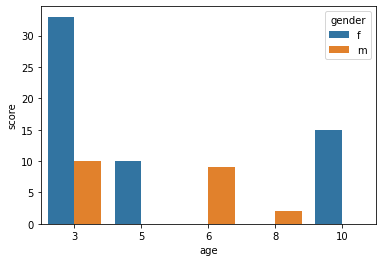

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.relplot(x='age', y='gender', data=df)
sns.barplot(x='age', y='score', hue = 'gender', data=df) # hue: 범례 (계열)

<AxesSubplot:xlabel='n_layer', ylabel='test_acc'>

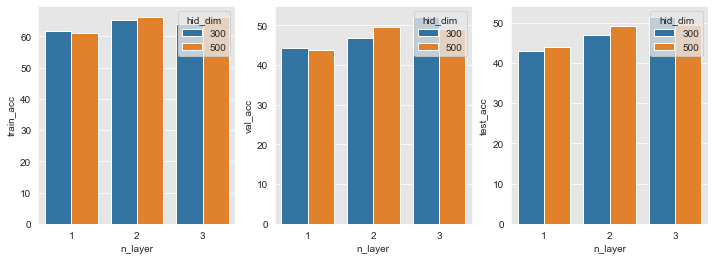

In [111]:
results = load_exp_result('exp1')


fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,4)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue = 'hid_dim', data=results, ax=ax[0]) 
sns.barplot(x='n_layer', y='val_acc', hue = 'hid_dim', data=results, ax=ax[1]) 
sns.barplot(x='n_layer', y='test_acc', hue = 'hid_dim', data=results, ax=ax[2]) 

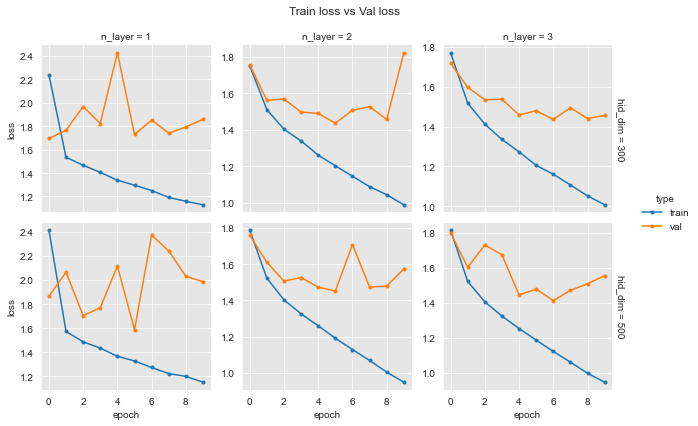

In [117]:
# Epoch에 따른 loss 변화

var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2] # 2줄 거치면 json의 row 하나 출력
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
# FacetGrid : 5차원 데이터 표현 핵심 
# row에는 hid_dim, col에서 n_layer 달라지게함
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False) 
# g.map : epoch, loss에 대한 내용으로 각각의 subplot 실행, 
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

KeyError: "['val_acc'] not in index"

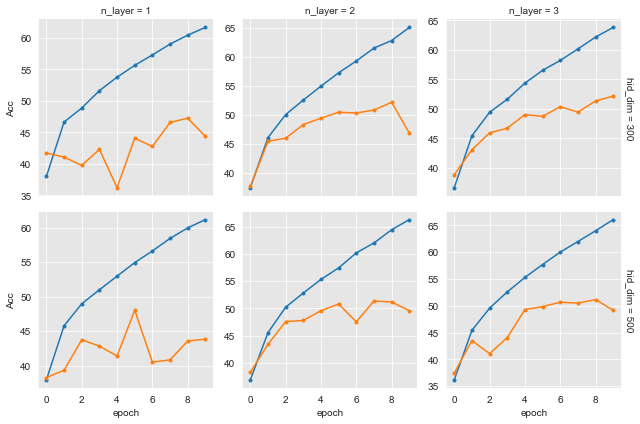

In [121]:
# Epoch에 따른 accuracy 변화 

var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Val Acc: {:1.3f}".format(list(metric.values)[0]) #기존 코드는 test로 돼있는데 val로 바꿔야함 
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'val_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [120]:
# Experiment 2


# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_dropout"

# ====== Model Capacity ====== #
args.n_layer = 3
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 300
args.act = 'relu'

# ====== Regularization ======= #
# args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
# args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.0001, 0.0005, 0.001, 0.005, 0.01]
list_var2 = [0, 0.1, 0.2, 0.3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # 실험변수명 자동화 처리 되도록 하는 구문, string attribute 값 지정되면 그 항목값으로 지정 
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0, epoch=10, exp_name='exp2_lr_dropout', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0001, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 40.78/45.28, Loss(train/val) 1.67/1.56. Took 8.68 sec
Epoch 1, Acc(train/val): 49.46/44.92, Loss(train/val) 1.44/1.56. Took 8.54 sec
Epoch 2, Acc(train/val): 53.73/47.73, Loss(train/val) 1.32/1.47. Took 8.54 sec
Epoch 3, Acc(train/val): 56.94/50.01, Loss(train/val) 1.23/1.42. Took 8.48 sec
Epoch 4, Acc(train/val): 59.45/49.16, Loss(train/val) 1.16/1.45. Took 8.59 sec
Epoch 5, Acc(train/val): 62.19/50.06, Loss(train/val) 1.09/1.43. Took 8.56 sec
Epoch 6, Acc(train/val): 64.99/50.85, Loss(train/val) 1.02/1.42. Took 8.60 sec
Epoch 7, Acc(train/val): 67.07/49.72, Loss(train/val) 0.96/1.45. Took 8.81 sec
Epoch 8, Acc(train/val): 69.65/49.04, Loss(train/val) 0.90/1.55. Took 8.59 sec
Epoch 9, Acc(train/val): 71.64/49.42, Loss(train/val) 0.8

Epoch 0, Acc(train/val): 39.63/40.50, Loss(train/val) 1.69/1.70. Took 8.74 sec
Epoch 1, Acc(train/val): 48.84/42.55, Loss(train/val) 1.44/1.65. Took 8.83 sec
Epoch 2, Acc(train/val): 53.12/47.11, Loss(train/val) 1.31/1.52. Took 8.69 sec
Epoch 3, Acc(train/val): 56.42/48.12, Loss(train/val) 1.22/1.52. Took 8.69 sec
Epoch 4, Acc(train/val): 59.40/46.17, Loss(train/val) 1.13/1.63. Took 8.73 sec
Epoch 5, Acc(train/val): 62.95/47.64, Loss(train/val) 1.05/1.55. Took 8.61 sec
Epoch 6, Acc(train/val): 65.44/49.87, Loss(train/val) 0.97/1.51. Took 8.72 sec
Epoch 7, Acc(train/val): 68.33/49.07, Loss(train/val) 0.88/1.61. Took 8.66 sec
Epoch 8, Acc(train/val): 71.60/49.50, Loss(train/val) 0.80/1.66. Took 8.59 sec
Epoch 9, Acc(train/val): 74.10/50.30, Loss(train/val) 0.73/1.68. Took 8.50 sec
Namespace(act='relu', dropout=0.1, epoch=10, exp_name='exp2_lr_dropout', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.001, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=

Epoch 1, Acc(train/val): 40.78/39.51, Loss(train/val) 1.65/1.98. Took 8.73 sec
Epoch 2, Acc(train/val): 45.55/42.83, Loss(train/val) 1.51/1.86. Took 8.69 sec
Epoch 3, Acc(train/val): 47.60/34.37, Loss(train/val) 1.44/2.01. Took 8.54 sec
Epoch 4, Acc(train/val): 50.44/42.64, Loss(train/val) 1.38/2.35. Took 8.60 sec
Epoch 5, Acc(train/val): 52.19/41.72, Loss(train/val) 1.33/1.81. Took 8.53 sec
Epoch 6, Acc(train/val): 53.73/36.46, Loss(train/val) 1.29/2.44. Took 8.50 sec
Epoch 7, Acc(train/val): 54.71/43.47, Loss(train/val) 1.26/1.83. Took 8.48 sec
Epoch 8, Acc(train/val): 56.32/46.91, Loss(train/val) 1.22/1.61. Took 8.47 sec
Epoch 9, Acc(train/val): 57.79/44.44, Loss(train/val) 1.18/1.76. Took 8.70 sec
Namespace(act='relu', dropout=0.1, epoch=10, exp_name='exp2_lr_dropout', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.01, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 28.73/32.42, Loss(train/val) 2.3